# Examples of the EMI paper
In this jupyter notebook are replicated the case studies of the paper [McLachlan et al. (in preparation)](https://www.journals.elsevier.com/computers-and-geosciences).

Table of contents:
* [Different forward models](#diff-fwd)
* [CS vs FS on synthetic conductive models](#cs-fs)
* [Effect of noise and height on the inversion](#noise)
* [Calibrated and not calibrated ERT with Boxford dataset](#calibration)
* [Inversion of a water-born survey over the river Leith](#river)
* [Time-lapse field application](#timelapse)
* [Capabilities of EMagPy](#capabilities)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import pandas as pd
import sys
sys.path.append('../src') # add path where emagpy is
from emagpy import Problem

datadir = 'examples/'
outputdir = 'figures/'

letters = ['a','b','c','d','e','f','g','h','i','j']

## Different forward models <a class="anchor" id="diff-fwd"></a>
Differences between CS-ECa, FSeq-ECa and LIN-ECa for a homogeneous and a heterogeneous case. (a) shows the differences over a homogeneous medium with increasing EC, (b) shows the differences over an increasing homogeneous medium when the device is operated at 1 m, (c) shows the differences over a heterogeneous medium with a fixed layer 1 thickness of 0.5 m and a fixed EC of 50 mS/m, and (d) shows the differences over a heterogeneous medium with a fixed layer 1 thickness of 0.5 m and a fixed EC of 50 mS/m when the device is operated at 1 m elevation. In all figures h is the device height above ground level.

In [2]:
# parameters for the synthetic model
coils = ['VCP4.49f10000h0', 'VCP4.49f10000h1']

# homogenous ground
condsHomo = np.ones((100,2))*np.arange(100)[:,None]+1
depths = np.ones((100,1))*1

# heterogeneous ground
condsHetero = np.ones((100,2))*np.arange(100)[:,None]+1
condsHetero[:,1] = 50
depths = np.ones((100,1))*0.5

# forward modelling
k = Problem()
k.setModels([depths, depths],[condsHomo, condsHetero])
dfsFSeq = k.forward(forwardModel='FSeq', coils=coils)
dfsFSlin = k.forward(forwardModel='FSlin', coils=coils)
dfsCS = k.forward(forwardModel='CS', coils=coils)

Forward modelling
Forward modelling
Forward modelling


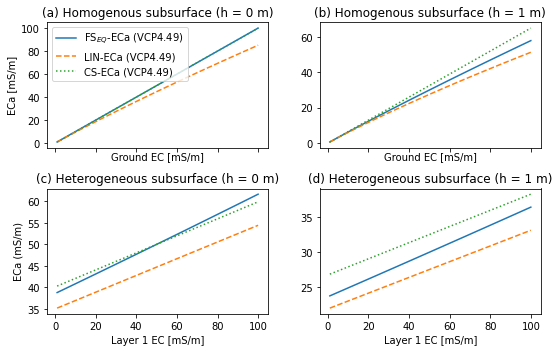

In [3]:
# figure
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(8, 5))
axs = axs.flatten()
ax = axs[0]
ax.set_title('(a) Homogenous subsurface (h = 0 m)')
ax.plot(condsHomo[:,0], dfsFSeq[0][coils[0]], '-', label = r'FS$_{EQ}$-ECa (VCP4.49)')
ax.plot(condsHomo[:,0], dfsFSlin[0][coils[0]], '--', label = 'LIN-ECa (VCP4.49)')
ax.plot(condsHomo[:,0], dfsCS[0][coils[0]], ':', label = 'CS-ECa (VCP4.49)')
ax.set_ylabel('ECa [mS/m]')
ax.set_xlabel('Ground EC [mS/m]')
ax.legend()

ax = axs[1]
ax.set_title('(b) Homogenous subsurface (h = 1 m)')
ax.plot(condsHomo[:,0], dfsFSeq[0][coils[1]], '-')
ax.plot(condsHomo[:,0], dfsFSlin[0][coils[1]], '--')
ax.plot(condsHomo[:,0], dfsCS[0][coils[1]], ':')
ax.set_xlabel('Ground EC [mS/m]')

ax = axs[2]
ax.set_title('(c) Heterogeneous subsurface (h = 0 m)')
ax.plot(condsHetero[:,0], dfsFSeq[1][coils[0]], '-')
ax.plot(condsHetero[:,0], dfsFSlin[1][coils[0]], '--')
ax.plot(condsHetero[:,0], dfsCS[1][coils[0]], ':')
ax.set_ylabel('ECa (mS/m)') 
ax.set_xlabel('Layer 1 EC [mS/m]')

ax = axs[3]
ax.set_title('(d) Heterogeneous subsurface (h = 1 m)')
ax.plot(condsHetero[:,0], dfsFSeq[1][coils[1]], '-')
ax.plot(condsHetero[:,0], dfsFSlin[1][coils[1]], '--')
ax.plot(condsHetero[:,0], dfsCS[1][coils[1]], ':')
ax.set_xlabel('Layer 1 EC [mS/m]') 

fig.tight_layout()
fig.savefig(outputdir + 'cs-maxwell.jpg', dpi=500)

## CS vs FS on synthetic conductive models <a class="anchor" id="cs-fs"></a>
Synthetic ECa values are generated using based on a two layer model without noise at 0 m and at 1 m above the ground using the coil orientation of the CMD Explorer. These ECa are then inverted using either the FSeq forward model or the CS.

The figure below shows the inverted models with (a) FSeq at 0 m, (b) FSeq at 1 m, (c) CS at 0 m, (d) CS at 1 m. The red lines denote the true interface between the two layers of 20 and 100 mS/m from top to bottom. The error bars show the standard deviation of the posterior distribution (based on the 10% best sample).

In [ ]:
# parameters for the synthetic model
nlayer = 2 # number of layers
npos = 20 # number of positions/sampling locations
conds = np.ones((npos, nlayer))*[10, 50] # EC in mS/m
x = np.linspace(0.1, 2, npos)[:,None]
depths = 0 + 2/(1+np.exp(-4*(x-1))) # depth of model

# defines coils configuration, frequency and height above the ground
coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0',
          'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
coils1 = ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1',
          'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']

# foward modelling
ks = []
for i, coils in enumerate([coils0, coils1, coils0, coils1]):
    k = Problem()
    k.setModels([depths], [conds])
    _ = k.forward(forwardModel='FSeq', coils=coils, noise=0.0)
    ks.append(k)
k.showResults() # display original model
k.show() # display ECa computed from forward modelling

for k, fm in zip(ks, ['FSeq','FSeq','CS','CS']):
    k.setInit(depths0=[0.5], fixedDepths=[False],
              conds0=[20, 20], fixedConds=[False, False]) # set initial values
    # invert using ROPE solver (RObust Parameter Estimation)
    k.invert(forwardModel=fm, method='ROPE', regularization='l1', alpha=0,
             bnds=[(0.01, 3), (0, 80), (0, 80)], rep=3000, njobs=-1)

Forward modelling
Forward modelling
Forward modelling
Forward modelling


  5%|▌         | 1/20 [00:00<00:03,  6.30it/s]

Survey 1/1


  0%|          | 0/20 [00:00<?, ?it/s]


Survey 1/1


 50%|█████     | 10/20 [01:29<00:58,  5.87s/it]

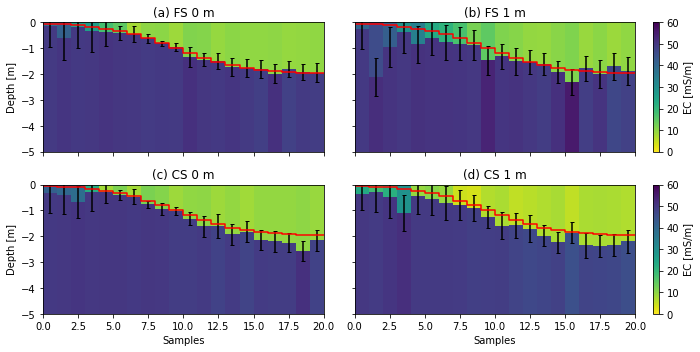

In [24]:
# figure
titles = ['(a) FS 0 m', '(b) FS 1 m', '(c) CS 0 m', '(d) CS 1 m']
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
axs = axs.flatten()
for i, k in enumerate(ks):
    ax = axs[i]
    k.showResults(ax=ax, vmin=0, vmax=60, maxDepth=5, errorbar=True)
    ax.step(-np.vstack([depths, depths[-1,:]]), 'r-', where='post')
    if i % 2 == 0:
        fig.axes[-1].remove() # remove colorbar
    else:
        ax.set_ylabel('')
    if i < 2:
        ax.set_xlabel('')
    ax.set_title(titles[i])
fig.tight_layout()
fig.savefig(outputdir + 'cs-maxwell-inv.jpg', dpi=500)

## Effect of noise and height on the inversion <a name="noise"></a>
All inversions are performed with the ROPE solver on a two-layer model with a varying depth. (a) Inversion with 0% noise with device on the ground. (b) Inversion with 2% noise on the ground. (c) Inversion with 0% noise at 1 m above the ground (d) Inversion with 2% noise at 1 m above the ground. The red line represents the true interface between the two layers.

In [32]:
# parameters for the synthetic model
nlayer = 2 # number of layer
npos = 20 # number of sampling positions
conds = np.ones((npos, nlayer))*[20, 100]
x = np.linspace(0.1, 2, npos)[:,None]
depths = 0.65 + 0.2 * np.sin(x*np.pi*2) # wave
coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0',
          'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
coils1 = ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1',
          'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']
coils = [coils0, coils0, coils1, coils1]
noises = [0, 0.05, 0, 0.05]
ks = []
# generate ECa using forward model
for i in range(4):
    k = Problem()
    k.setModels([depths], [conds])
    _ = k.forward(forwardModel='FSeq', coils=coils[i], noise=noises[i])
    ks.append(k)

# invert
for k in ks:
    k.setInit(depths0=np.array([0.5]), fixedDepths=[False])
    k.invert(forwardModel='FSeq', method='ROPE', regularization='l1',
             bnds=[(0.05, 2.5), (5, 150), (5, 150)], rep=1000, njobs=-1)

Forward modelling
Forward modelling
Forward modelling
Forward modelling


  0%|          | 0/20 [00:00<?, ?it/s]

Survey 1/1


  0%|          | 0/20 [00:00<?, ?it/s]


Survey 1/1


  0%|          | 0/20 [00:00<?, ?it/s]


Survey 1/1


  0%|          | 0/20 [00:00<?, ?it/s]


Survey 1/1


100%|██████████| 20/20 [01:30<00:00,  9.45s/it]


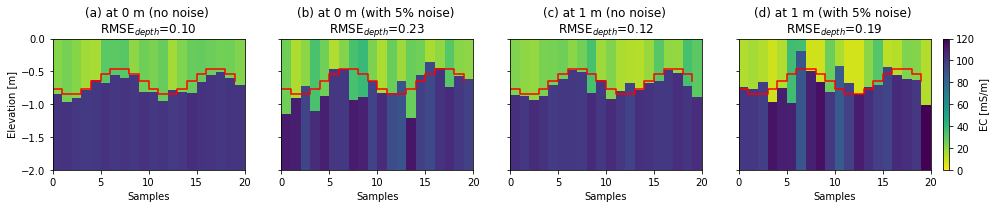

In [33]:
# graph of inverted values
titles = ['(a) at 0 m (no noise)', '(b) at 0 m (with 5% noise)',
          '(c) at 1 m (no noise)', '(d) at 1 m (with 5% noise)']
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14,3))
for i in range(4):
    ax = axs[i]
    ks[i].showResults(ax=ax, vmin=0, vmax=120, maxDepth=2)
    rmseDepths = np.sqrt(np.sum((ks[i].depths[0][:,0] - depths[:,0])**2)/len(depths[:,0]))
    ax.set_title('{:s} \nRMSE$_{{depth}}$={:.2f}'.format(titles[i], rmseDepths))
    ax.step(np.arange(depths.shape[0]), -depths, 'r', where='post') # true depth
    if i < 3:
        fig.axes[-1].remove()
    if i > 0:
        ax.set_ylabel('')
fig.savefig(outputdir + 'inv-noise.jpg', dpi=500)

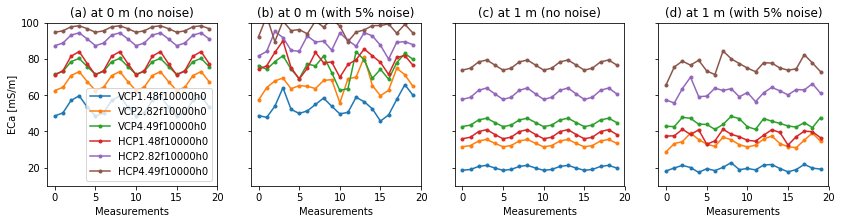

In [78]:
# graph of apparent values
titles = ['at 0 m (no noise)', 'at 0 m (with 5% noise)',
          'at 1 m (no noise)', 'at 1 m (with 5% noise)']
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14,3))
for i in range(4):
    ax = axs[i]
    ks[i].show(ax=ax, vmin=10, vmax=100)
    ax.set_title('({:s}) {:s}'.format(letters[i], titles[i]))
    if i > 0:
        ax.get_legend().remove()
        ax.set_ylabel('')

## Calibrated and not calibrated ERT with Boxford dataset <a class="anchor" id="calibration"></a>
To obtain quantitative EMI measurements, a calibration is needed. One way to perform this calibration is to use an inverted resistivity model from ERT and perform a forward EM model on it. We then match the generated ECa with the ECa measured on the ERT transect (see [Lavoué et al. 2010](https://doi.org/10.3997/1873-0604.2010037)).

The results are shown in the figure below. Smoothly inverted non-calibrated (a) and calibrated (b) EMI data with the corresponding ERT inversion (c). The red line shows the true depth of the peat intrusive penetration measurements.

In [2]:
# load inverted data
sys.path.append('../../pyr2/src')
from resipy import R2

kres = R2()
kres.dirname = datadir + 'boxford-calib/wd'
kres.createSurvey(datadir + 'boxford-calib/protocol.dat', ftype='Protocol') # read the survey file
kres.elec = np.zeros((96,3))
kres.elec[:,0] = np.arange(0, 96*0.5, 0.5)
kres.createMesh(typ='quad', elemx=2, xgf=2, zf=1.25, zgf=2,doi=4) # generate quadrilateral mesh
kres.getResults()
res = np.array(kres.meshResults[0].attr_cache['Resistivity(Ohm-m)'])
kres.meshResults[0].attr_cache['Conductivity(mS/m)'] = 1000/res

API path =  /media/jkl/data/phd/tmp/pyr2/src/resipy
ResIPy version =  2.1.0
Working directory is: /media/jkl/data/phd/tmp/pyr2/src/resipy/invdir
clearing the dirname
2171/2171 reciprocal measurements NOT found.
0 measurements error > 20 %
magErr/phiErr columns detected, will be used in protocol.dat
Creating quadrilateral mesh...done
1/1 results parsed (1 ok; 0 failed)


Survey 1/1
43/43 inverted
VCP1.48f10000h1: ECa(ERT) = 0.25 * ECa(EMI) + 2.15 (R^2=0.38)
VCP2.82f10000h1: ECa(ERT) = 0.40 * ECa(EMI) + 2.47 (R^2=0.48)
VCP4.49f10000h1: ECa(ERT) = 0.48 * ECa(EMI) + 2.09 (R^2=0.53)
HCP1.48f10000h1: ECa(ERT) = 0.49 * ECa(EMI) + 3.55 (R^2=0.36)
HCP2.82f10000h1: ECa(ERT) = 0.73 * ECa(EMI) + 1.85 (R^2=0.53)
HCP4.49f10000h1: ECa(ERT) = 0.58 * ECa(EMI) + 2.49 (R^2=0.33)
VCP1.48f10000h1: ECa(ERT) = 0.25 * ECa(EMI) + 2.15 (R^2=0.38)
VCP2.82f10000h1: ECa(ERT) = 0.40 * ECa(EMI) + 2.47 (R^2=0.48)
VCP4.49f10000h1: ECa(ERT) = 0.48 * ECa(EMI) + 2.09 (R^2=0.53)
HCP1.48f10000h1: ECa(ERT) = 0.49 * ECa(EMI) + 3.55 (R^2=0.36)
HCP2.82f10000h1: ECa(ERT) = 0.73 * ECa(EMI) + 1.85 (R^2=0.53)
HCP4.49f10000h1: ECa(ERT) = 0.58 * ECa(EMI) + 2.49 (R^2=0.33)
Correction is applied.
Survey 1/1
43/43 inverted


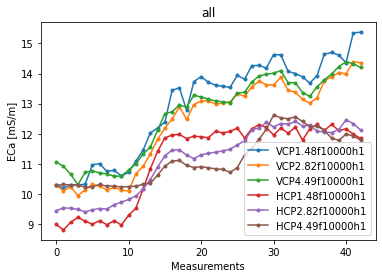

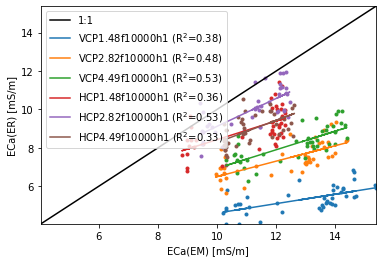

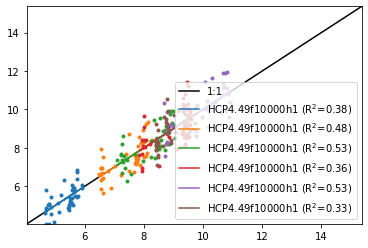

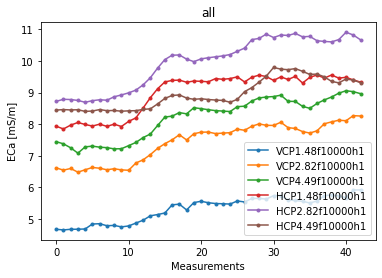

In [3]:
fnameEC = datadir + 'boxford-calib/eri_ec.csv'
fnameECa = datadir + 'boxford-calib/eca_calibration2.csv'

# non calibrated
k1 = Problem()
k1.createSurvey(fnameECa)
k1.show()
k1.setInit(depths0=np.arange(0.05, 3, 0.05))
k1.invert(forwardModel='CSgn', alpha=0.01)

# ERT calibrated
k2 = Problem()
k2.createSurvey(fnameECa)
k2.calibrate(fnameECa, fnameEC, forwardModel='CS') # plot calibration
k2.calibrate(fnameECa, fnameEC, forwardModel='CS', apply=True) # apply the calibration
k2.show()
k2.setInit(depths0=np.arange(0.05, 3, 0.05))
k2.invert(forwardModel='CSgn', alpha=0.01)

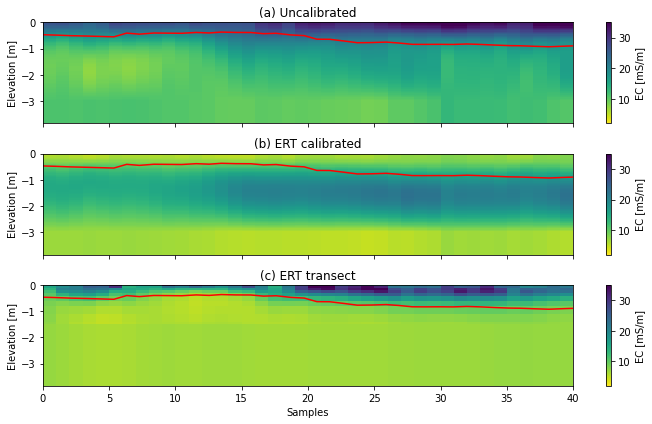

In [4]:
# figure
fig, axs = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(10,6))
peatdepths = pd.read_csv(datadir + 'boxford-calib/peat depth.dat', sep="\t")
ax = axs[0]
k1.showResults(ax=ax, vmin=2, vmax=35)
ax.plot(peatdepths['distance (m)'], -peatdepths['depth (m)'], 'r-')
ax.set_title('(a) Uncalibrated')
ax.set_xlabel('')
ax = axs[1]
k2.showResults(ax=ax, vmin=2, vmax=35)
ax.plot(peatdepths['distance (m)'], -peatdepths['depth (m)'], 'r-')
ax.set_title('(b) ERT calibrated')
ax.set_xlabel('')
ax = axs[2]
kres = Problem()
kres.importModel(datadir + 'boxford-calib/wd/ertSection.csv')
kres.models[0] = kres.models[0][::4,:] # because taken avery 0.25 m
kres.depths[0] = kres.depths[0][::4,:]
kres.showResults(ax=ax, vmin=2, vmax=35, maxDepth=1.5)
ax.set_title('(c) ERT transect')
ax.plot(peatdepths['distance (m)'], -peatdepths['depth (m)'], 'r-')
ax.set_xlim([0, 40])
ax.set_aspect('auto')
fig.tight_layout()
fig.savefig(outputdir + 'calibrated-inv.jpg', dpi=500)

## Inversion of an water-born survey over the river Leith <a class="anchor" id="river"></a>
EMI can be a useful tool to investigate the interface between surface water and ground-water. In this case, EMI measurements were collected with a CMD Explorer on a kayak above the river. Using prior knowledge of the bottom of the water, EMI data can be inverted. We can see here that area of higher EC correspond quite well with area of higher hydraulic heads ([Binley et al., 2013](https://doi.org/10.1002/wrcr.20214)). This is because the ground-water EC is higher than the river EC, so in this case, EMI help us to identify zone of ground-water upwelling.

  0%|          | 0/543 [00:00<?, ?it/s]

Removing 9 NaN from survey
Survey 1/1


100%|██████████| 543/543 [02:03<00:00,  4.06it/s]


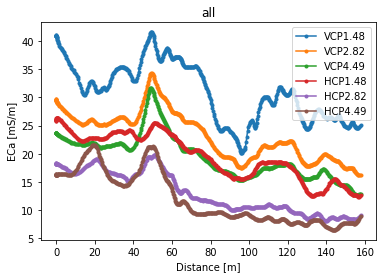

In [10]:
# fixed depths
k = Problem()
k.createSurvey(datadir + 'leith/leith_dataset.csv')
k.show(dist=True)
depths = np.c_[wdepths, wdepths + 0.2, wdepths + 0.45, wdepths + 0.75,
               wdepths + 1.1, wdepths + 1.5, wdepths + 2]
# initial model with top layer (river) with fixed EC of 48 mS/m (measured)
k.setInit(depths0=depths, conds0=[48, 20, 20, 20, 20, 20, 20, 20],
          fixedConds=[True, False, False, False, False, False, False, False])
k.invert(njobs=-1, beta=0.0, alpha=0.1) # beta > 0 will cause lateral smoothing
# k.setInit(depths0=np.linspace(0.1, 2, 20))
# k.invert(forwardModel='CSgn')

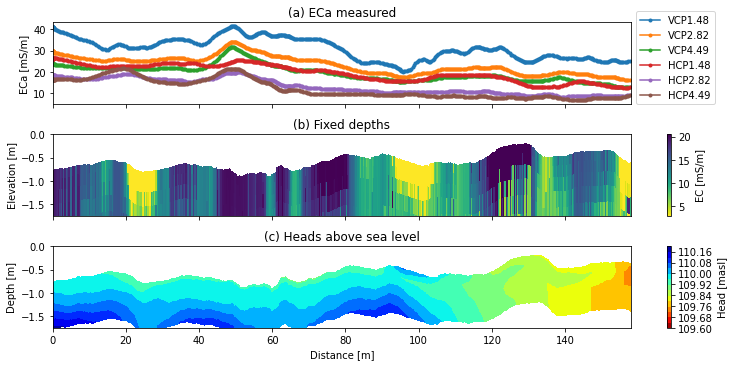

In [11]:
# figure
fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
ax0 = axs[0]
ax1 = axs[1]
ax2 = axs[2]

k.show(ax=ax0, dist=True)
ax0.set_title('(a) ECa measured')
ax0.set_xlabel('')
ax0.get_legend().remove()
ax0.legend(k.coils, bbox_to_anchor=(1,1.2))

current_cmap = mpl.cm.get_cmap() # set NaN as white
current_cmap.set_bad(color='white')
k.models[0][:,0] = np.nan # blank river as it's fixed EC
k.showResults(ax=ax1, contour=False, dist=True)
ax1.set_title('(b) Fixed depths')
ax1.set_xlabel('')
ax1.set_ylim([-1.75, 0])

ax2.set_title('(c) Heads above sea level')
df = k.surveys[0].df
xx = np.ones((df.shape[0], 4))*df['dist'].values[:,None]
yy = np.ones((df.shape[0], 4))*df['depth'].values[:,None]
yy = yy + np.array([[0, 0.2, 0.5, 1]])
heads = df[['Stage(m)', 'H20cm(m)', 'H50cm(m)', 'H100cm(m)']].values
cax = ax2.contourf(xx, -yy, heads, cmap='jet_r', levels=15)
ax2.set_xlabel('Distance [m]')
ax2.set_ylabel('Depth [m]')
ax2.set_ylim([-1.75, 0])
fig.colorbar(cax, ax=ax2, label='Head [masl]') # meter above sea level

# adjust the x axis of subplot 1 to match the others
pos1 = ax1.get_position()
pos2 = ax0.get_position()
ax0.set_position([pos1.x0,pos2.y0,pos1.width,pos2.height])
fig.savefig(outputdir + 'river.jpg', dpi=500)

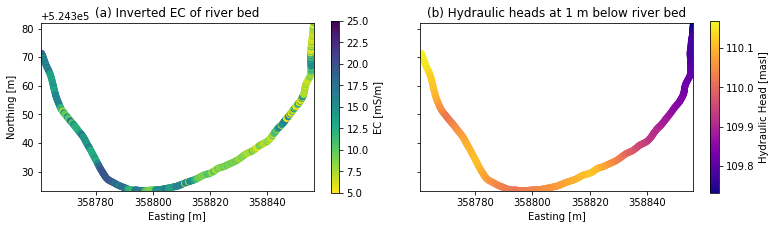

In [19]:
# figure of spatial data
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,3))
ax = axs[0]
k.showSlice(islice=-2, ax=ax, vmin=5, vmax=25)
ax.set_title('(a) Inverted EC of river bed')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_aspect('equal')
ax = axs[1]
ax.set_title('(b) Hydraulic heads at 1 m below river bed')
df = k.surveys[0].df
cax = ax.scatter(df['x'], df['y'], s=35, c=df['H100cm(m)'], cmap='plasma')
ax.set_xlabel('Easting [m]')
ax.set_aspect('equal')
fig.colorbar(cax, ax=ax, label='Hydraulic Head [masl]') # masl = meter above sea level
fig.tight_layout()
fig.savefig(outputdir + 'river-layer2.jpg', dpi=500)

## Time-lapse field application <a class="anchor" id="timelapse"></a>
Time-lapse EMI can be used to monitor the change in soil moisture in the field. In this case, time-lapse EMI survey were collected under different winter wheat varieties. We can invert the EMI data by computing the change in ECa and inverting this change using the Gauss-Newton solver (`CSgn`) as demonstrated in [Whalley et al. (2017)](https://doi.org/10.1007/s11104-016-3161-1).

The figure below shows the evolution of the inverted change in electrical conductivity throughout the growth season (a to d) and of the measured soil moisture content from neutron probe (e to h). EC and WC changes are expressed as absolute difference relative to 2017-03-16 (models a and e). Deeper and larger decrease in EC is observed throughout the season mainly (b, c and d) following the change in soil moisture (f, g and h) mainly driven by root water uptake.

In [22]:
# inversion of change
fnames = [
        datadir + 'timelapse-wheat/2017-03-16.csv',
        datadir + 'timelapse-wheat/2017-04-03.csv',
        datadir + 'timelapse-wheat/2017-04-27.csv',
        datadir + 'timelapse-wheat/2017-05-16.csv']
k = Problem()
k.createTimeLapseSurvey(fnames) # import all surveys
k.setInit(depths0=np.linspace(0.1, 2, 10)) # smooth multiple fixed depths model
k.computeApparentChange() # compute change in ECa compared to first survey
k.invert(forwardModel='CSgn', alpha=0.07) # Gauss-Newton routine

Trimming surveys and only keep common positions
Matching positions between surveys for time-lapse inversion...20 in common...done in 0.0115s
Computing relative ECa compared to background (1st survey).
Survey 1/4
20/20 inverted
Survey 2/4
20/20 inverted
Survey 3/4
20/20 inverted
Survey 4/4
20/20 inverted


In [23]:
# we use the structure of EMagPy to import the soil moisture data and plot them
fnamesWC = [
        datadir + 'timelapse-wheat/170316_wc.csv',
        datadir + 'timelapse-wheat/170405_wc.csv',
        datadir + 'timelapse-wheat/170426_wc.csv',
        datadir + 'timelapse-wheat/170518_wc.csv',
        ]
kwc = Problem()
kwc.importModel(fnamesWC)
for i in range(len(fnamesWC)):
    kwc.models[i] = kwc.models[i][30:50,:]
    kwc.depths[i] = kwc.depths[i][30:50,:]
kwc.computeChange()

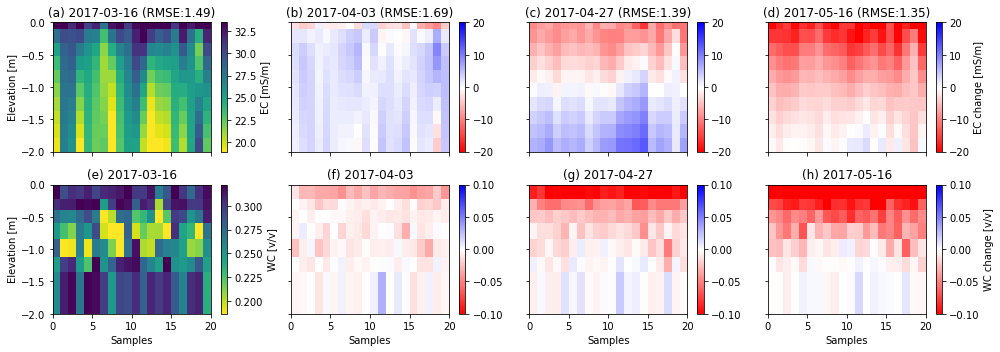

In [24]:
# graph of inverted conductivities change relative to background
rmse = k.getRMSE()
fig, axs = plt.subplots(2, 4, figsize=(14, 5), sharex=True, sharey=True)
for i, s in enumerate(k.surveys):
    ax = axs[0, i]
    if i == 0:
        k.showResults(i, ax=ax, contour=False, maxDepth=2)
    else:
        k.showResults(i, ax=ax, vmin=-20, vmax=20, cmap='bwr_r', contour=False, maxDepth=2)
    ax.set_title('({:s}) {:s} (RMSE:{:.2f})'.format(letters[i], s.name, rmse['all'].values[i]))
    ax.set_xlabel('')
    if i > 2:
        fig.axes[-1].set_ylabel('EC change [mS/m]')
    if i > 0:
        ax.set_ylabel('')
        if i != 3:
            fig.axes[-1].set_ylabel('')
    
    ax = axs[1, i]
    if i == 0:
        kwc.showResults(i, ax=ax, contour=False, maxDepth=2)
        fig.axes[-1].set_ylabel('WC [v/v]')
    else:
        kwc.showResults(i, ax=ax, cmap='bwr_r', vmin=-0.1, vmax=0.1, contour=False, maxDepth=2)
    ax.set_title('({:s}) {:s}'.format(letters[i+4], s.name))
    if i > 2:
        fig.axes[-1].set_ylabel('WC change [v/v]')
    if i > 0:
        ax.set_ylabel('')
        if i != 3:
            fig.axes[-1].set_ylabel('')
fig.tight_layout()
fig.savefig(outputdir + 'inv-timelapse2.jpg', dpi=500)

## Capabilities of EMagPy <a class="anchor" id="capabilities"></a>
Below is the script used to generated the miniature for the 'capabilities' figure of the paper.

Forward modelling
Deleted 13/60 measurements
dataset shrunk of 2 measurements
VCP0.71 0.53 * x + 2.34 (R=0.54)
HCP0.71 0.22 * x + 10.44 (R=0.22)
Transformation to LIN ECa for CMD Mini-Explorer at F-0m calibration
found 766 / 3792 crossing points
bounds = None
Survey 1/1
45 measurements inverted (0 converged)


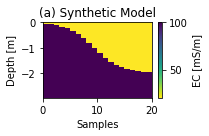

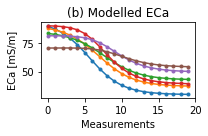

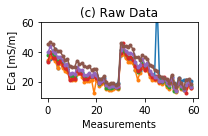

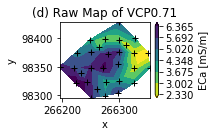

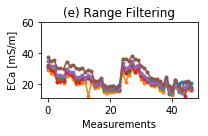

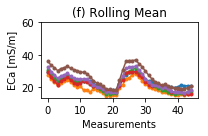

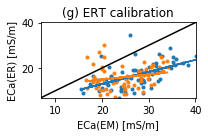

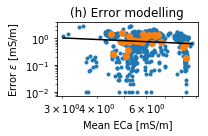

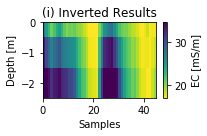

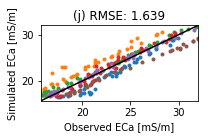

In [12]:
figsize = (3,2)

# forward modelling
nlayer = 2
npos = 20
conds = np.ones((npos, nlayer))*[20, 100]
x = np.linspace(0.1, 2, npos)[:,None]
depths = 0 + 2/(1+np.exp(-4*(x-1)))
coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0',
          'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
k = Problem()
k.setModels([depths], [conds])
dfs = k.forward(forwardModel='FS', coils=coils0, noise=0)

fig, ax = plt.subplots(figsize=figsize)
k.showResults(ax=ax)
ax.set_title('(a) Synthetic Model')
fig.axes[-1].set_ylabel('EC [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-forward-model.jpg')

fig, ax = plt.subplots(figsize=figsize)
k.show(ax=ax)
ax.get_legend().remove()
ax.set_title('(b) Modelled ECa')
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-forward-show.jpg')


# create EMI model
k = Problem()
k.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k.surveys[0].df = k.surveys[0].df[:60]
#k.coils = k.coils[:3] # just VCP
#k.surveys[0].coils = k.surveys[0].coils[:3]

# data display
fig, ax = plt.subplots(figsize=figsize)
k.show(ax=ax, vmax=60)
ax.get_legend().remove()
ax.set_title('(c) Raw Data')
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-show.jpg')

# data map
fig, ax = plt.subplots(figsize=figsize)
k2 = Problem()
k2.createSurvey(datadir + 'saprolite/regolith.csv')
k2.convertFromNMEA()
k2.showMap(coil=k2.coils[1], ax=ax, contour=True, pts=True)
ax.set_title('(d) Raw Map of VCP0.71')
fig.axes[-1].set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-showMap.jpg')

# filter range
fig, ax = plt.subplots(figsize=figsize)
k.filterRange(vmin=10, vmax=40)
k.show(ax=ax, vmax=60)
ax.get_legend().remove()
ax.set_title('(e) Range Filtering')
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-filterRange.jpg')

# filter pick
#fig, ax = plt.subplots()
#k.show(ax=ax, vmax=60)
#fig.savefig(outputdir + 'cap-filterPick.jpg')

# filter smooth
fig, ax = plt.subplots(figsize=figsize)
k.rollingMean()
k.show(ax=ax, vmax=60)
ax.set_title('(f) Rolling Mean')
ax.get_legend().remove()
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-smooth.jpg')

# ERT calibration
fig, ax = plt.subplots(figsize=figsize)
k.calibrate(datadir + 'calib/dfeca2.csv', datadir + 'calib/dfec.csv', ax=ax)
ax.get_legend().remove()
ax.set_title('(g) ERT calibration')
fig.tight_layout()
fig.savefig(outputdir + 'cap-calib.jpg')

# EMI error modelling
k2 = Problem() # need other dataset as cover-crop doesn't have cross-over points
k2.importGF(fnameLo = datadir + 'potatoes/potatoesLo.dat')
k2.convertFromNMEA()
fig, ax = plt.subplots(figsize=figsize)
k2.crossOverPoints(ax=ax, coil=k.coils[1])
ax.set_title('(h) Error modelling')
ax.get_legend().remove()
ax.set_xlabel('Mean ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-error.jpg')

# Inverse results
fig, ax = plt.subplots(figsize=figsize)
k.invert()
k.showResults(ax=ax, contour=False)
ax.set_title('(i) Inverted Results')
fig.axes[-1].set_ylabel('EC [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-showResults.jpg')

# Inverse quality
fig, ax = plt.subplots(figsize=figsize)
k.showOne2one(ax=ax)
ax.get_legend().remove()
ax.set_title('(j) ' + ax.get_title())
fig.tight_layout()
fig.savefig(outputdir + 'cap-one2one.jpg')